# Лабораторная работа 5

---

Задание для 9-го варианта:

Функция: $\frac{1}{cos (x)}$. Отрезок интерполяции: $[0, \pi/3]$.

Импорт необходимых библиотек и вспомагательные функции:

In [77]:
import numpy 
import matplotlib.pyplot as plt
import math
import scipy.linalg
import scipy.interpolate as inter

def product( val, n ): # произведение разностей координат
    mul = 1
    for i in range(n):
        if i: mul *= val - x[i-1]
        yield mul
def niceCubicPolynomial(p):
    tmp = ""
    if p["a"] == 1:
        tmp += " x^3"
    elif p["a"] != 0:
        tmp += "%.2fx^3" % p["a"]
    if p["b"] == 1:
        tmp += "\t+ x^2"
    elif p["b"] != 0:
        tmp += "\t+ %.2fx^2" % p["b"]
    else:
        tmp += "\t\t"
    if p["c"] == 1:
        tmp += "\t+ x"
    elif p["c"] != 0:
        tmp += "\t+ %.2fx" % p["c"]
    else:
        tmp += "\t\t"
    if p["d"] != 0:
        tmp += "\t+ %.2f" % p["d"]
    return tmp
def dif(x,w):
    M = x.shape[0]
    A = numpy.zeros((M,M))
    A[:,0] = w
    for j in range(1,M):
        for i in range(M-j):
            #print ((x[i+j]-x[i]))
            #print("A+",A[i+1,j-1])
            #print("A1",A[i,j-1])
            A[i,j] = (A[i+1,j-1]-A[i,j-1])#/(x[i+j]-x[i])

    b1=numpy.copy(A[0,:])
    b2=numpy.zeros(M)
    for j in range(M):
        b2[j] = A[M-1-j,j]
        
    return A,b1,b2

Таблица интерполяции:

In [47]:
x = numpy.arange(0, numpy.pi/3, numpy.pi/30)
y = 1/numpy.cos(x) #  [math.cos(i) for i in x]
print(x, y, sep="\n")

[ 0.          0.10471976  0.20943951  0.31415927  0.41887902  0.52359878
  0.62831853  0.73303829  0.83775804  0.9424778 ]
[ 1.          1.00550828  1.02234059  1.05146222  1.09463628  1.15470054
  1.23606798  1.34563273  1.49447655  1.70130162]


Коэффициенты полинома Лагранжа:

In [48]:
C = []
for n in range(len(x)): # вычисляем коэффициенты
    p = product( x[n], n+1 )
    C.append( (y[n]-sum(C[k]*next(p) for k in range(n)) )/next(p) )
print(C)

[1.0, 0.052600195227942216, 0.51631411706187058, 0.14009268338041422, 0.27643052841261251, 0.18318943545246086, 0.23557755385996218, 0.2611342380390872, 0.36578358222881208, 0.57773624806139701]


Функция Лагранжа:

In [49]:
def lagranz(x,y,t):
    z = 0
    for j in range(len(y)):
        p1 = 1
        p2 = 1
        for i in range(len(x)):
            if i==j:
                p1=p1*1; p2=p2*1   
            else: 
                p1=p1*(t-x[i])
                p2=p2*(x[j]-x[i])
        z=z+y[j]*p1/p2
    return z

Отображение графика:

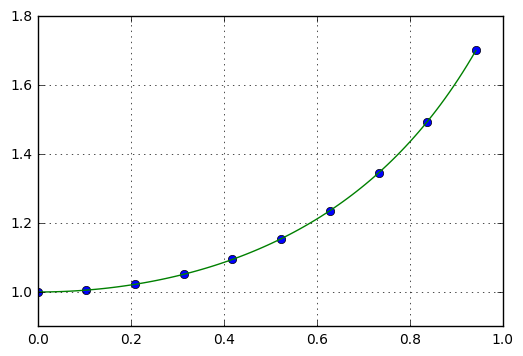

In [50]:
xnew=numpy.linspace(numpy.min(x),numpy.max(x),100)
ynew=[lagranz(x,y,i) for i in xnew]
# plt.figure(figsize=(10,10))  # если figsize=(8, 6) мало
plt.plot(x,y,'o',xnew,ynew)
plt.grid(True)
plt.show()

In [86]:
def newton(x,w,form=1):
    M = w.shape[0]
    A,b1,b2 = dif(x,w)
    q = numpy.poly1d([1,-x[0]])/(x[1]-x[0])
    p = numpy.poly1d(b1[0])
    a = numpy.poly1d(1)
    for i in range(1,M):
        a = a*(q-i+1)/(i)
        p += a*b1[i]
    return p

In [87]:
result = newton(x, y)
print(result)

        9         8         7         6         5         4           3
0.5777 x - 1.812 x + 2.648 x - 2.057 x + 1.051 x - 0.108 x + 0.05635 x
           2
 + 0.4947 x + 0.0002027 x + 1


In [51]:
def getSpline(points):
    points = sorted(points, key=lambda point: point["x"])

    n = len(points) - 1

    A = numpy.zeros(shape=(4*n,4*n))
    b = numpy.zeros(shape=(4*n,1))

    for i in range(0, n):
        # 2n
        A[i][4*i+0] = points[i]["x"]**3
        A[i][4*i+1] = points[i]["x"]**2
        A[i][4*i+2] = points[i]["x"]
        A[i][4*i+3] = 1
        b[i] = points[i]["y"]

        A[n+i][4*i+0] = points[i+1]["x"]**3
        A[n+i][4*i+1] = points[i+1]["x"]**2
        A[n+i][4*i+2] = points[i+1]["x"]
        A[n+i][4*i+3] = 1
        b[n+i] = points[i+1]["y"]

        # 2n-2
        if i == 0:
            continue
        # точка i - внутренняя
        A[2*n+(i-1)][4*(i-1)+0] = 3*points[i]["x"]**2
        A[2*n+(i-1)][4*(i-1)+1] = 2*points[i]["x"]
        A[2*n+(i-1)][4*(i-1)+2] = 1
        A[2*n+(i-1)][4*(i-1)+0+4] = -3*points[i]["x"]**2
        A[2*n+(i-1)][4*(i-1)+1+4] = -2*points[i]["x"]
        A[2*n+(i-1)][4*(i-1)+2+4] = -1
        b[2*n+(i-1)] = 0

        A[3*n+(i-1)][4*(i-1)+0] = 6*points[i]["x"]
        A[3*n+(i-1)][4*(i-1)+1] = 2
        A[3*n+(i-1)][4*(i-1)+0+4] = -6*points[i]["x"]
        A[3*n+(i-1)][4*(i-1)+1+4] = -2
        b[3*n+(i-1)] = 0
    A[3*n-1+0][0+0] += 6*points[0]["x"]
    A[3*n-1+0][0+1] += 2
    b[3*n-1+0] += 0

    A[3*n+n-1][4*(n-1)+0] += 6*points[n]["x"]
    A[3*n+n-1][4*(n-1)+1] += 2
    b[3*n+n-1] += 0

    x = scipy.linalg.solve(A, b)
    spline = []
    for i in range(0, n):
        spline.append({"u": points[i]["x"], "v": points[i+1]["x"],
                        "a": float(x[4*i+0]),
                        "b": float(x[4*i+1]),
                        "c": float(x[4*i+2]),
                        "d": float(x[4*i+3])})
    return spline

In [52]:
points = []
for i in range (1, 10):
    points.append({"x": x[i], "y": y[i]})
print(points)

[{'y': 1.0055082795635164, 'x': 0.10471975511965977}, {'y': 1.0223405948650293, 'x': 0.20943951023931953}, {'y': 1.0514622242382672, 'x': 0.31415926535897931}, {'y': 1.0946362785060468, 'x': 0.41887902047863906}, {'y': 1.1547005383792515, 'x': 0.52359877559829882}, {'y': 1.2360679774997896, 'x': 0.62831853071795862}, {'y': 1.3456327296063759, 'x': 0.73303828583761832}, {'y': 1.4944765498646086, 'x': 0.83775804095727813}, {'y': 1.7013016167040798, 'x': 0.94247779607693793}]


In [53]:
spline = getSpline(points)

In [54]:
for p in spline:
    tmp = "[%.2f, %.2f]:" % (p["u"], p["v"])
    tmp += niceCubicPolynomial(p)
    print(tmp)

[0.10, 0.21]:2.20x^3	+ -0.69x^2	+ 0.21x	+ 0.99
[0.21, 0.31]:-0.31x^3	+ 0.89x^2	+ -0.12x	+ 1.01
[0.31, 0.42]:0.57x^3	+ 0.06x^2	+ 0.14x	+ 0.98
[0.42, 0.52]:0.50x^3	+ 0.15x^2	+ 0.10x	+ 0.99
[0.52, 0.63]:1.28x^3	+ -1.08x^2	+ 0.74x	+ 0.88
[0.63, 0.73]:0.38x^3	+ 0.61x^2	+ -0.32x	+ 1.10
[0.73, 0.84]:6.84x^3	+ -13.60x^2	+ 10.10x	+ -1.44
[0.84, 0.94]:-11.47x^3	+ 32.42x^2	+ -28.45x	+ 9.32


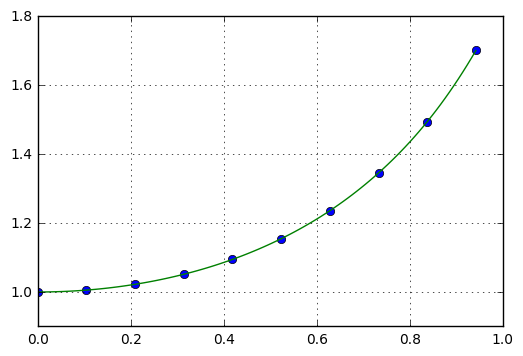

In [78]:
xnew=numpy.linspace(numpy.min(x),numpy.max(x),100)
tck = inter.splrep(x, y, s=0)
ynew = inter.splev(xnew, tck, der=0)
plt.plot(x,y, 'o', xnew, ynew)
plt.grid(True)
plt.show()

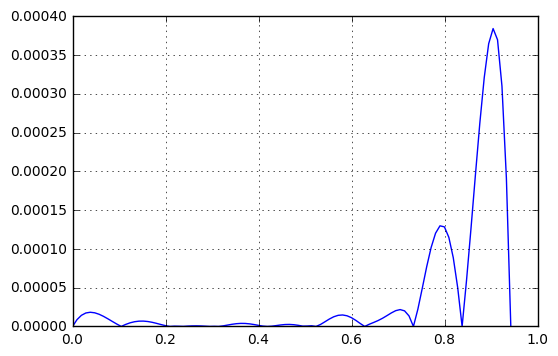

In [80]:
xnew=numpy.linspace(numpy.min(x),numpy.max(x),100)
tck = inter.splrep(x, y, s=0)
ynew = inter.splev(xnew, tck, der=0)
plt.plot(xnew, abs(ynew - 1/numpy.cos(xnew)))
plt.grid(True)
plt.show()